In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import matplotlib.pyplot as plt

In [3]:
# ==============================================
# Configurações do Processo de Ornstein-Uhlenbeck
# ==============================================

class OUProcess:
    def __init__(self, num_channels, seq_length, rho=0.1, sigma=0.2):
        self.rho = rho
        self.sigma = sigma
        self.num_channels = num_channels
        self.seq_length = seq_length
        
        # Pré-computa a matriz de precisão tridiagonal
        self.precision_matrix = self._construct_precision_matrix()
        
    def _construct_precision_matrix(self):
        """Constrói a matriz de precisão do processo OU (tridiagonal)."""
        diag = (1 + self.rho**2) * torch.eye(self.seq_length)
        off_diag = -self.rho * torch.diag(torch.ones(self.seq_length - 1), 1)  # Correção aqui
        precision_matrix = diag + off_diag + off_diag.T
        return precision_matrix / (self.sigma**2)


    
    def sample(self, batch_size):
        """Amostra do processo OU usando a propriedade Gauss-Markov."""
        x = torch.zeros(batch_size, self.num_channels, self.seq_length)
        for t in range(1, self.seq_length):
            x[:, :, t] = x[:, :, t-1] * (1 - self.rho) + torch.randn_like(x[:, :, t]) * self.sigma
        return x

In [4]:

# ==============================================
# Módulo 1: Carregamento de Dados Neurofisiológicos
# ==============================================

class NeurophysioDataset(Dataset):
    def __init__(self, data_dir, window_size=1000):
        self.data_dir = data_dir
        self.window_size = window_size
        
        # Carrega e empilha canais
        self.channel_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
        self.channels = [np.load(os.path.join(data_dir, f)) for f in self.channel_files]
        
        # Alinhamento temporal
        self.min_length = min(c.shape[0] for c in self.channels)
        self.num_windows = self.min_length // self.window_size

    def __len__(self):
        return self.num_windows

    def __getitem__(self, idx):
        start = idx * self.window_size
        end = start + self.window_size
        x = np.stack([c[start:end] for c in self.channels])  # [C, L]
        x = torch.FloatTensor(x)  # [channels, sequence_length]
        return x

In [5]:
# ==============================================
# Módulo 2: Arquitetura do Denoiser com Convoluções Estruturadas
# ==============================================

class StructuredConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=15, dilation=1):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2)*dilation,
            dilation=dilation
        )
        self.norm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)  # Correto! Mantém [batch, canais, seq_length]
        x = self.norm(x)
        return F.gelu(x)



class Denoiser(nn.Module):
    def __init__(self, num_channels, hidden_dims=[128, 256, 512]):
        super().__init__()
        self.num_channels = num_channels
        
        # Encoder com múltiplas escalas temporais
        self.encoder = nn.ModuleList([
            StructuredConvBlock(num_channels, hidden_dims[0], kernel_size=31),  # 23 → 128
            StructuredConvBlock(hidden_dims[0], hidden_dims[1], kernel_size=63),  # 128 → 256
            StructuredConvBlock(hidden_dims[1], hidden_dims[2], kernel_size=127),  # 256 → 512 (correto!)
         ])

        
        # Time embedding para capturar dinâmica do processo de difusão
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),  # Redução inicial
            nn.GELU(),
            nn.Linear(128, num_channels)  # Saída deve ser igual ao número de canais de x
        )

        
        # Decoder com skip connections
        self.decoder = nn.ModuleList([
            StructuredConvBlock(hidden_dims[2] + hidden_dims[2], hidden_dims[1]),  # 512+512 → 256
            StructuredConvBlock(hidden_dims[1] + hidden_dims[1], hidden_dims[0]),  # 256+256 → 128
            StructuredConvBlock(hidden_dims[0] + hidden_dims[0], num_channels)  # 128+128 → 23
        ])


    def forward(self, x, t):

        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)

        for i, layer in enumerate(self.decoder):
            skip_connection = skips[-(i+1)]
            if x.shape[1] + skip_connection.shape[1] == layer.conv.in_channels:
                x = torch.cat([x, skip_connection], dim=1)  # Apenas se os canais forem compatíveis
            else:
                print(f"❌ ERRO: Concatenação inválida! Esperado {layer.conv.in_channels}, mas recebeu {x.shape[1]} + {skip_connection.shape[1]}")
                exit()  # Encerra a execução para depuração
            x = layer(x)

        t_emb = self.time_embed(t.unsqueeze(1).float()).unsqueeze(-1).expand(-1, -1, x.shape[2])
        return x + t_emb  # Injeção temporal final

In [6]:
# ==============================================
# Módulo 3: Processo de Difusão com OU
# ==============================================

class OU_Diffusion:
    def __init__(self, denoiser, T=1000, rho=0.1, sigma=0.2):
        self.denoiser = denoiser
        self.T = T
        self.rho = rho
        self.sigma = sigma
        
        # Cronograma de ruído adaptativo
        self.beta = torch.linspace(1e-4, 0.02, T) * self._spectral_adjustment()
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
    def _spectral_adjustment(self):
        """Ajusta o cronograma de ruído para respeitar a lei de potência 1/f"""
        t = torch.arange(self.T, dtype=torch.float32)
        return 1 / (1 + t**0.5)
    
    def forward_process(self, x_0, t):
        """Processo de difusão com ruído OU"""
        ou = OUProcess(x_0.size(1), x_0.size(2), self.rho, self.sigma)
        noise = ou.sample(x_0.size(0))
        
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise

    def train_step(self, x_0, optimizer):
        optimizer.zero_grad()
        x_0 = x_0  # Já está no formato correto [batch, canais, seq_length]

        # Amostragem do passo temporal
        t = torch.randint(0, self.T, (x_0.size(0),))
        
        # Processo de difusão
        x_t, noise = self.forward_process(x_0, t)
        
        # Predição do ruído
        pred_noise = self.denoiser(x_t, t)
        
        # Perda com regularização espectral
        loss = F.mse_loss(pred_noise, noise)
        spectral_loss = self._spectral_consistency(x_0, pred_noise)
        total_loss = loss + 0.1 * spectral_loss
        
        total_loss.backward()
        optimizer.step()
        return total_loss.item()
    
    def _spectral_consistency(self, real, fake):
        """Perda de consistência espectral no domínio da frequência"""
        real_fft = torch.fft.rfft(real, dim=-1).abs()
        fake_fft = torch.fft.rfft(fake, dim=-1).abs()
        return F.mse_loss(real_fft, fake_fft)

    @torch.no_grad()
    def sample(self, num_samples, seq_length):
        """Amostragem reversa com processo OU"""
        ou = OUProcess(self.denoiser.num_channels, seq_length, self.rho, self.sigma)
        x_t = ou.sample(num_samples)
        
        for t in reversed(range(self.T)):
            alpha_t = self.alpha[t]
            alpha_bar_t = self.alpha_bar[t]
            
            pred_noise = self.denoiser(x_t, torch.tensor([t]*num_samples))
            
            if t > 0:
                noise = ou.sample(num_samples)
            else:
                noise = 0
                
            x_t = (x_t - (1 - alpha_t)/torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_t)
            x_t += torch.sqrt(self.beta[t]) * noise
            
        return x_t

In [7]:
# ==============================================
# Pipeline de Treinamento e Avaliação
# ==============================================

def train(data_dir, num_epochs=500, batch_size=16):
    dataset = NeurophysioDataset(data_dir)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    denoiser = Denoiser(num_channels=len(dataset.channel_files))
    diffusion = OU_Diffusion(denoiser)
    optimizer = torch.optim.AdamW(denoiser.parameters(), lr=1e-4)
    loss_log = []

    for epoch in range(num_epochs):
        avg_loss = 0
        for batch in loader:
            loss = diffusion.train_step(batch, optimizer)
            avg_loss += loss
        current_loss = avg_loss / len(loader)
        loss_log.append(current_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss/len(loader):.4f}")


    torch.save(denoiser.state_dict(), 'denoiser.pt')

    return denoiser, diffusion,loss_log

def spectral_analysis(signal, fs=200):
    """Calcula a densidade espectral de potência"""
    from scipy.signal import welch
    f, psd = welch(signal, fs=fs, nperseg=512)
    return f, psd

In [8]:
print(torch.cuda.is_available())


for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)
       
    # Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

False
Using CPU


In [9]:
# Treinamento
denoiser, diffusion, loss_log = train("./00007656_s010_t000_processed_data", num_epochs=500, batch_size=16)

Epoch 1/500 | Loss: 4714013.3382
Epoch 2/500 | Loss: 3446960.6029
Epoch 3/500 | Loss: 2389462.2721
Epoch 4/500 | Loss: 1757502.6213
Epoch 5/500 | Loss: 1148284.1893
Epoch 6/500 | Loss: 882746.2868
Epoch 7/500 | Loss: 567076.8141
Epoch 8/500 | Loss: 391113.5703
Epoch 9/500 | Loss: 285810.1801
Epoch 10/500 | Loss: 168837.1415
Epoch 11/500 | Loss: 127869.4173
Epoch 12/500 | Loss: 76639.7246
Epoch 13/500 | Loss: 50854.6878
Epoch 14/500 | Loss: 29143.7023
Epoch 15/500 | Loss: 17870.1478
Epoch 16/500 | Loss: 9992.5032
Epoch 17/500 | Loss: 5653.2455
Epoch 18/500 | Loss: 3633.1501
Epoch 19/500 | Loss: 1908.8845
Epoch 20/500 | Loss: 1092.6851
Epoch 21/500 | Loss: 714.4557
Epoch 22/500 | Loss: 373.4019
Epoch 23/500 | Loss: 210.3802
Epoch 24/500 | Loss: 117.3040
Epoch 25/500 | Loss: 71.6387
Epoch 26/500 | Loss: 52.9044
Epoch 27/500 | Loss: 40.1139
Epoch 28/500 | Loss: 35.1092
Epoch 29/500 | Loss: 31.8690
Epoch 30/500 | Loss: 30.4263
Epoch 31/500 | Loss: 28.4998
Epoch 32/500 | Loss: 27.9897
Epoch 

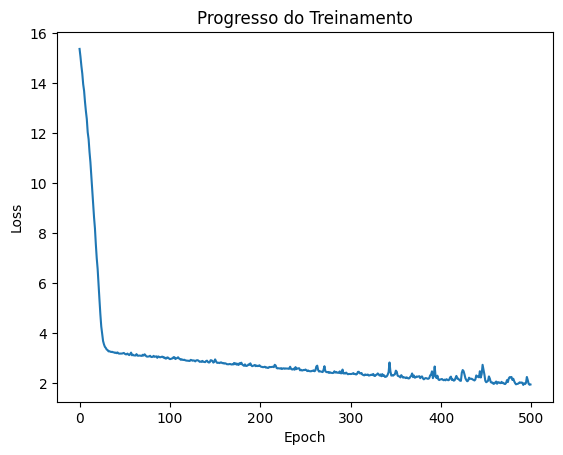

In [10]:
# Plotagem da perda ao longo do treinamento
plt.plot(np.log(loss_log))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Progresso do Treinamento")
plt.savefig("loss_log.png")

In [11]:
# Geração de amostras
synthetic = diffusion.sample(num_samples=10, seq_length=1000)

In [12]:
# Avaliação espectral
dataset = NeurophysioDataset("./00007656_s010_t000_processed_data")
real_sample = dataset[0].numpy()
synthetic_sample = synthetic[0].numpy()

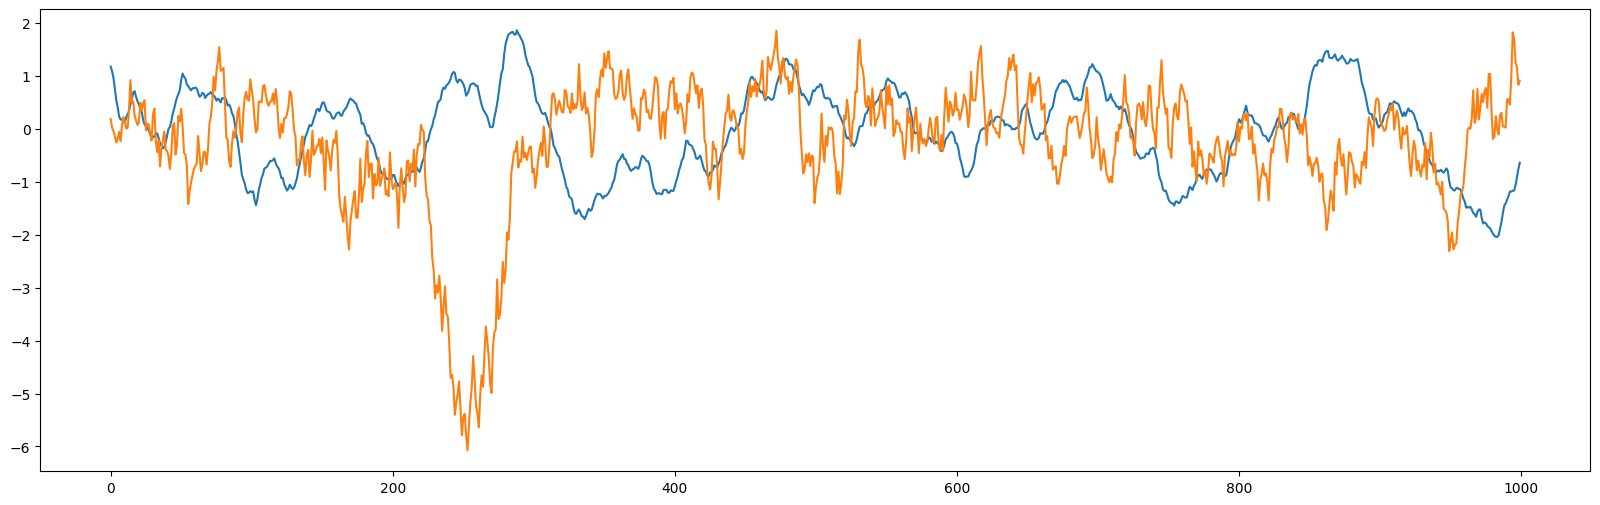

In [22]:
plt.figure(figsize=(20,6))
plt.plot(real_sample[0], label='Real')
plt.plot(synthetic_sample[0], label='Sintético')



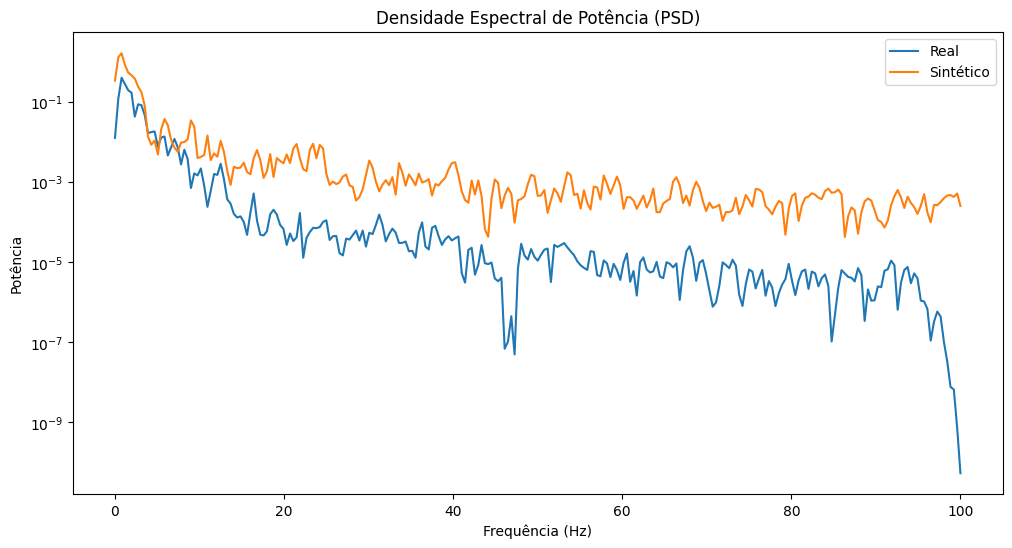

In [14]:
f_real, psd_real = spectral_analysis(real_sample[0])
f_syn, psd_syn = spectral_analysis(synthetic_sample[0])

# Plotagem
plt.figure(figsize=(12,6))
plt.semilogy(f_real, psd_real, label='Real')
plt.semilogy(f_syn, psd_syn, label='Sintético')
plt.title("Densidade Espectral de Potência (PSD)")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Potência")
plt.legend()
plt.show()